<h1><center>Emoji'On : Reconnaissance des émotions</center></h1>
<h2><center>Part 2 : Deep Learning (ANN Model)</center></h2>
<center><img src="https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2F32cf5db1-69d0-4e21-8dec-710068e7a355.jpg&w=1280&q=75" alt="iIllustration" title="title"  style="object-fit:cover; width:800px; height:250px;"/></center>

> __*Created by Charley lebarbier*__

## Objectives :  
*Réaliser une application pour placer des émojis sur le visage de personnes détectés dans une vidéo en fonction de leur émotion.*  

## Livrables :  

- Notebook cohérent sur :  
    - l'analyse, 
    - la préparation des données, la création et l'entrainement du/des modèles et visualisation des performances  
</br>
- Application fonctionnelle

-----------------
-----------------

## Prepare the workspace

In [1]:
# -- General Import
import keras
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

# -- Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# -- Other
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report, confusion_matrix

2023-02-13 17:32:22.141308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 17:32:23.446661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 17:32:23.446784: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-13 17:32:28.210010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
## -------------- Data Load -------------- ##
df = pd.read_csv('../data/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Prepare Dataset

In [3]:
x_train, x_val, x_test = [], [], []
y_train, y_val, y_test = [], [], []

for idx, row in df.iterrows():
    img = row['pixels'].split(" ")           # - Get the img pixel

    if row['Usage'] == 'Training':
        x_train.append(np.array(img))        # - Convert img in array
        y_train.append(row['emotion'])       # - Get the img label

    elif row['Usage'] == 'PublicTest':
        x_val.append(np.array(img))
        y_val.append(row['emotion'])

    elif row['Usage'] == 'PrivateTest':
        x_test.append(np.array(img))
        y_test.append(row['emotion'])

In [4]:
# -- Convert in array for next step
x_train = np.array(x_train, dtype='float')
y_train = np.array(y_train)

x_val = np.array(x_val, dtype='float')
y_val = np.array(y_val)

x_test = np.array(x_test, dtype='float')
y_test = np.array(y_test)

In [5]:
# -- Reshape at the proper form for the model i.e. add 3 other dimensions
# -- 48, 48 (size of img) and 1 for the channel because graymode
# -- Then normalize it

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1) / 255.0
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1) / 255.0
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1) / 255.0


# -- Reshape the target with the number of category

y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [6]:
x_test.shape, y_test.shape

((3589, 48, 48, 1), (3589, 7))

----------------------------------------

## ANN (Artificial Neural Networks)

In [7]:
input_shape = (48, 48, 1)       # img size 48px on 48px, 1 channel = Grayscale
batch_size = 64

### Training / Validation

In [16]:
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(7, activation='softmax')
])

ann_model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                73760     
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 119,015
Trainable params: 119,015
Non-tr

In [17]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          verbose = 1,
                          restore_best_weights = True,
                          mode = "min",
                          patience = 5),

checkpoint = ModelCheckpoint('best_ann_model.h5',
                             monitor = "val_loss",
                             verbose = 1,
                             save_best_only = True,
                             mode = "min"),

callbacks = [earlystop, checkpoint, PlotLossesKeras()]

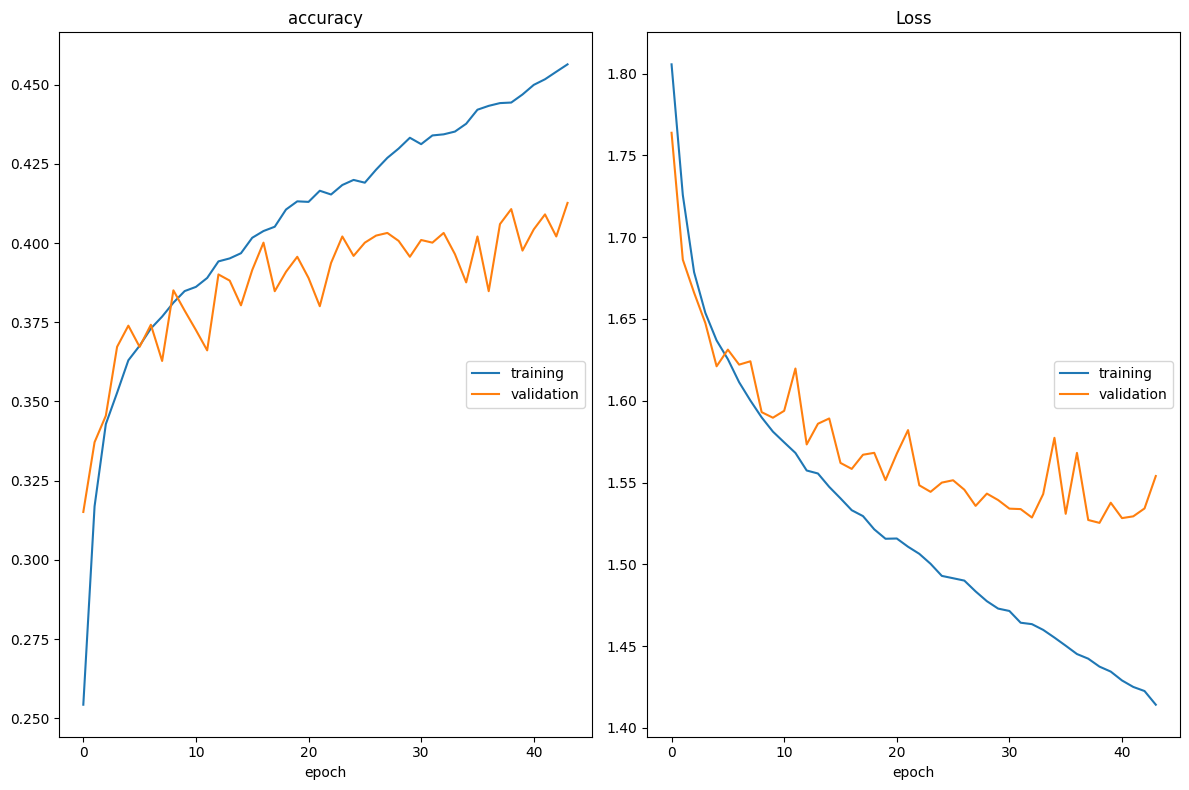

accuracy
	training         	 (min:    0.254, max:    0.456, cur:    0.456)
	validation       	 (min:    0.315, max:    0.413, cur:    0.413)
Loss
	training         	 (min:    1.414, max:    1.806, cur:    1.414)
	validation       	 (min:    1.525, max:    1.764, cur:    1.554)
449/449 [==============================] - 4s 10ms/step - loss: 1.4142 - accuracy: 0.4564 - val_loss: 1.5540 - val_accuracy: 0.4126
Epoch 44: early stopping


In [18]:
essay_ann_1 = ann_model.fit(
        x_train,
        y_train,
        validation_data = (x_val, y_val),

        epochs = 50,
        batch_size = batch_size,

        verbose = 1,
        callbacks = callbacks,
)

### Test

In [22]:
y_pred = ann_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

113/113 [==============================] - 0s 3ms/step


### Metrics and Confusion Matrix

In [23]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred, digits=3, zero_division=False))

              precision    recall  f1-score   support

           0      0.280     0.267     0.273       491
           1      0.000     0.000     0.000        55
           2      0.253     0.142     0.182       528
           3      0.467     0.752     0.576       879
           4      0.331     0.298     0.314       594
           5      0.597     0.423     0.495       416
           6      0.392     0.363     0.377       626

    accuracy                          0.403      3589
   macro avg      0.331     0.321     0.317      3589
weighted avg      0.382     0.403     0.380      3589



Text(95.72222222222221, 0.5, 'Truth')

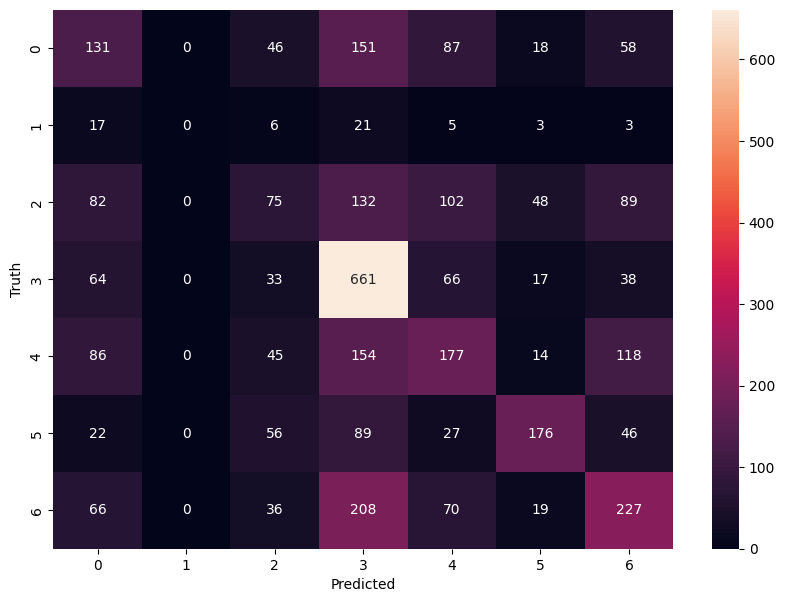

In [28]:
# -- get the x_test labels
y_actual = []

for a in y_test:
    y_actual.append(np.argmax(a))
y_actual[:10]


# -- Display the Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_actual, predictions=y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Conclusion :

L'ANN n'arrive à être bon qu'à 40%.  
Il est bon sur les catégories Happy et Surprized puis sur Sad et Neutral. On note par contre qu'il n'est pas bon pour Angry et Fear. Concernant Disgust, il n'arrive même pas à en labellisé une correctement.  

La matrice de confusion montre qu'il a tendance à classer majoritairement Disgust soit en Angry ou en Happy.

Pour avoir une image claire de ce qu'il l'induit en erreur, nous pouvons afficher un échantillon d'image tiré de la base test en indiquant la prédiction et la réalité.

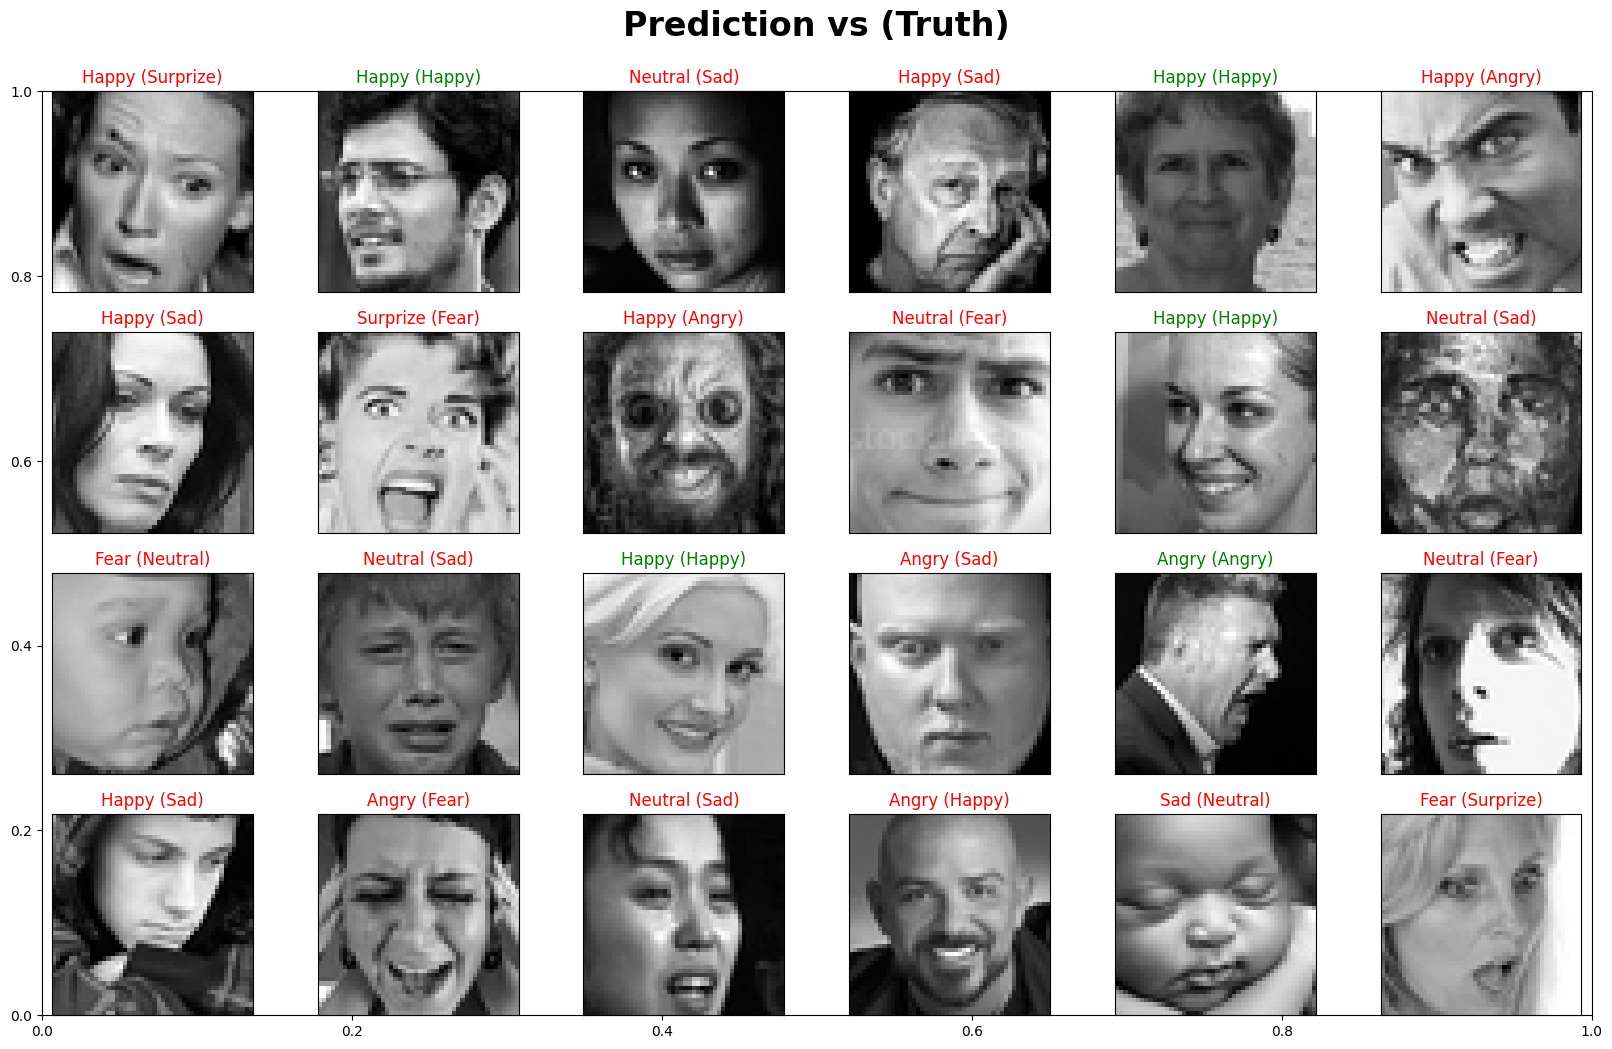

In [36]:
def check_images(x_test:np.ndarray, y_pred:np.ndarray) -> None:
    '''
    function to plot images with their lables (prediction vs (truth))
    '''

    # -- list of available emotions in the dataset
    emotions = { 0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad",
                 5:"Surprize", 6:"Neutral" }

    figure = plt.figure(figsize=(20, 12))
    plt.title("Prediction vs (Truth)",
              fontdict={'fontsize': 24, 'fontweight':'bold'}, pad=40)

    for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
        ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]),cmap="gray")

        predict_index = emotions[(y_pred[index])]
        true_index = emotions[np.argmax(y_test,axis=1)[index]]

        ax.set_title("{} ({})".format((predict_index), (true_index)),
                      color=("green" if predict_index == true_index else "red"))

#### Saving

In [37]:
ann_model.save('../model_save/ann_model.h5')

------------

## End  

On a ainsi un aperçu des résultats de notre modèle et des erreurs qu'il peut commettre.  

Pour améliorer le modèle, nous pourrions augmenter la base de données par de la Data Augmentation, néanmoins vu le modèle en ANN, les résultats ne seraient que très légèrement augmenter.  

Ainsi nous préférons passer sur un modèle en CNN qui apportera un résultat de réussite plus important.